<a href="https://colab.research.google.com/github/jsebastianquiroga/IMAGE_VIDEO_PROCESSING_PUJ/blob/main/presentaciones/fourier_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import equalize_hist

Downloading...
From: https://drive.google.com/uc?id=1qk89d0D4jTV99bk5C0qEPoAMa3E7IqvW
To: /content/against_the_light.png
100%|██████████| 23.9k/23.9k [00:00<00:00, 17.6MB/s]


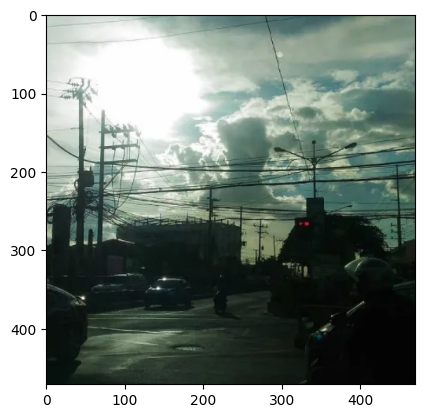

In [1]:
import gdown
import cv2
from matplotlib import pyplot as plt

# Download the image from Google Drive
url = 'https://drive.google.com/uc?id=1qk89d0D4jTV99bk5C0qEPoAMa3E7IqvW'
output = 'against_the_light.png'
gdown.download(url, output, quiet=False)

# Read and display the image
dark_image = cv2.imread('against_the_light.png', cv2.IMREAD_COLOR)
dark_image = cv2.cvtColor(dark_image, cv2.COLOR_BGR2RGB)
plt.imshow(dark_image)
plt.show()


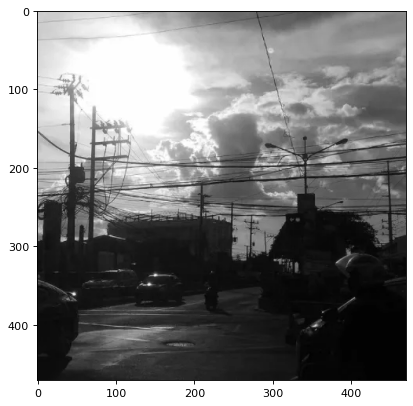

In [ ]:
dark_image_grey = cv2.cvtColor(dark_image, cv2.COLOR_RGB2GRAY)
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(dark_image_grey, cmap='gray')

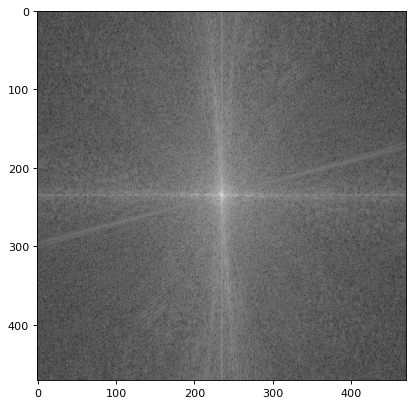

In [ ]:
dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(dark_image_grey))
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')

En la imagen podemos ver dos distorsiones muy claras. Las líneas verticales y horizontales blancas se refieren a los elementos horizontales y verticales nítidos de la imagen. Veamos qué pasa si enmascaramos uno de ellos.

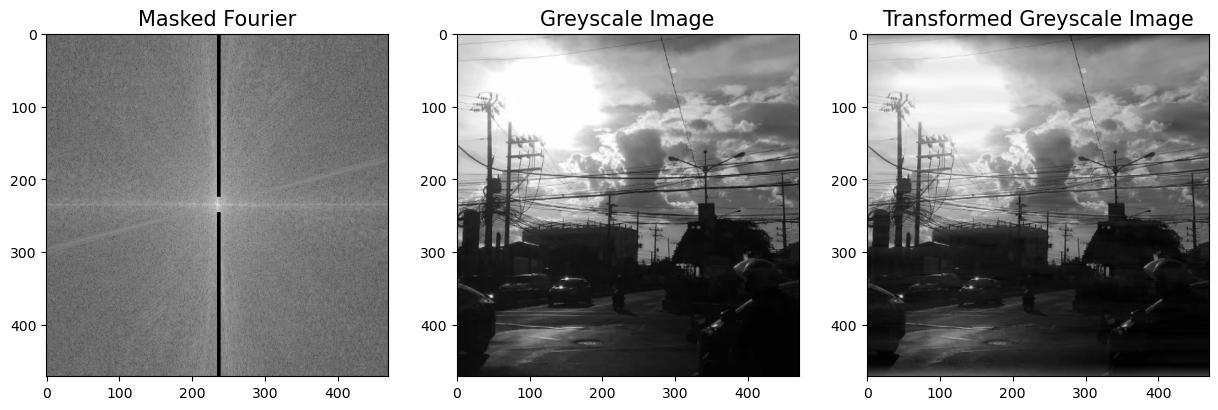

In [ ]:
def fourier_masker_ver(image, i):
    f_size = 15
    image_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(image_grey))
    dark_image_grey_fourier[:225, 235:240] = i
    dark_image_grey_fourier[-225:,235:240] = i
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')
    ax[0].set_title('Masked Fourier', fontsize = f_size)
    ax[1].imshow(image_grey, cmap = 'gray')
    ax[1].set_title('Greyscale Image', fontsize = f_size)
    ax[2].imshow(abs(np.fft.ifft2(dark_image_grey_fourier)), cmap='gray')
    ax[2].set_title('Transformed Greyscale Image', fontsize = f_size)

fourier_masker_ver(dark_image, 1)

Podemos ver que los cables de alimentación horizontales se han reducido significativamente en tamaño. Como experimento interesante, veamos qué pasaría si en su lugar enmascaráramos la línea horizontal.

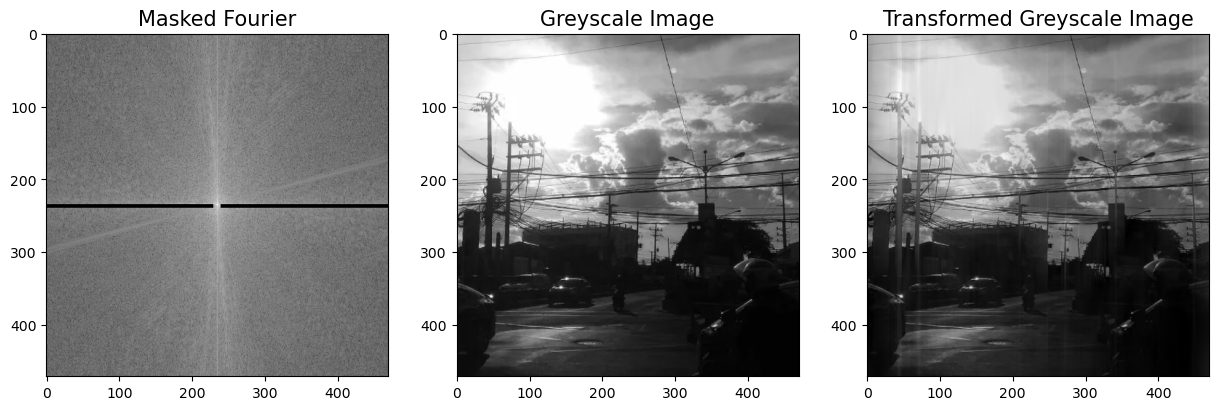

In [ ]:
def fourier_masker_hor(image, i):
    f_size = 15
    image_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    dark_image_grey_fourier = np.fft.fftshift(np.fft.fft2(image_grey))
    dark_image_grey_fourier[235:240, :230] = i
    dark_image_grey_fourier[235:240,-230:] = i
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(np.log(abs(dark_image_grey_fourier)), cmap='gray')
    ax[0].set_title('Masked Fourier', fontsize = f_size)
    ax[1].imshow(image_grey, cmap = 'gray')
    ax[1].set_title('Greyscale Image', fontsize = f_size)
    ax[2].imshow(abs(np.fft.ifft2(dark_image_grey_fourier)), cmap='gray')
    ax[2].set_title('Transformed Greyscale Image', fontsize = f_size)

fourier_masker_hor(dark_image, 1)

Podemos ver que todos los aspectos verticales de la imagen han sido emborronados. Esto es muy notorio en los postes eléctricos. Aunque útil en algunos entornos, esto claramente no es útil aquí.

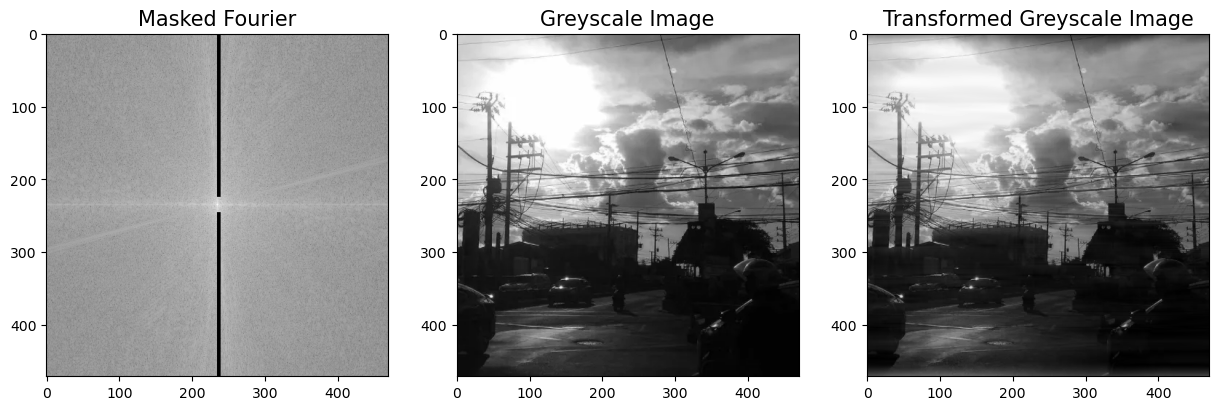

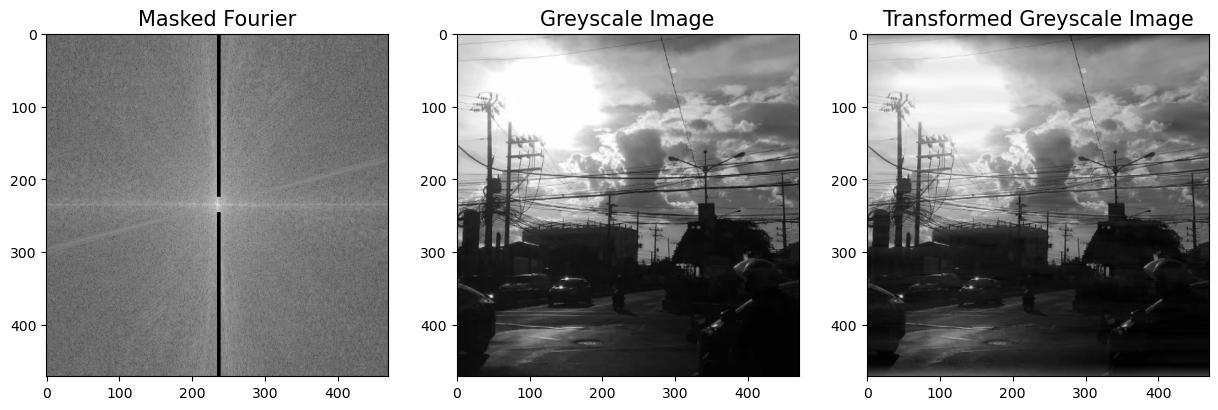

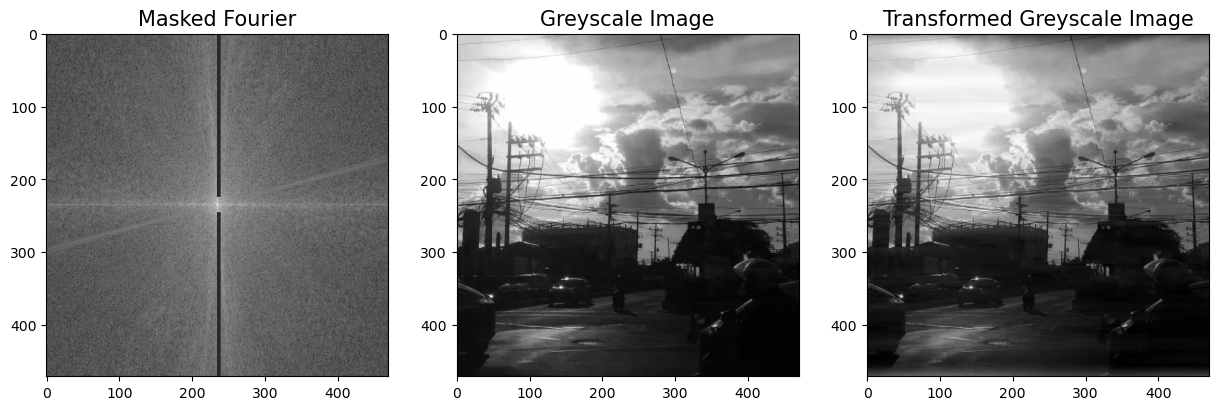

In [ ]:
def fourier_iterator(image, value_list):
    for i in value_list:
        fourier_masker_ver(image, i)

fourier_iterator(dark_image, [0.001, 1, 100])

Podemos ver que la disminución del valor casi no tiene efecto sobre la imagen original, sin embargo, el aumento del valor parece oscurecer la imagen original. Como prácticamente no hay diferencia entre el valor más pequeño y 1, vamos a ceñirnos a 1 por simplicidad.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


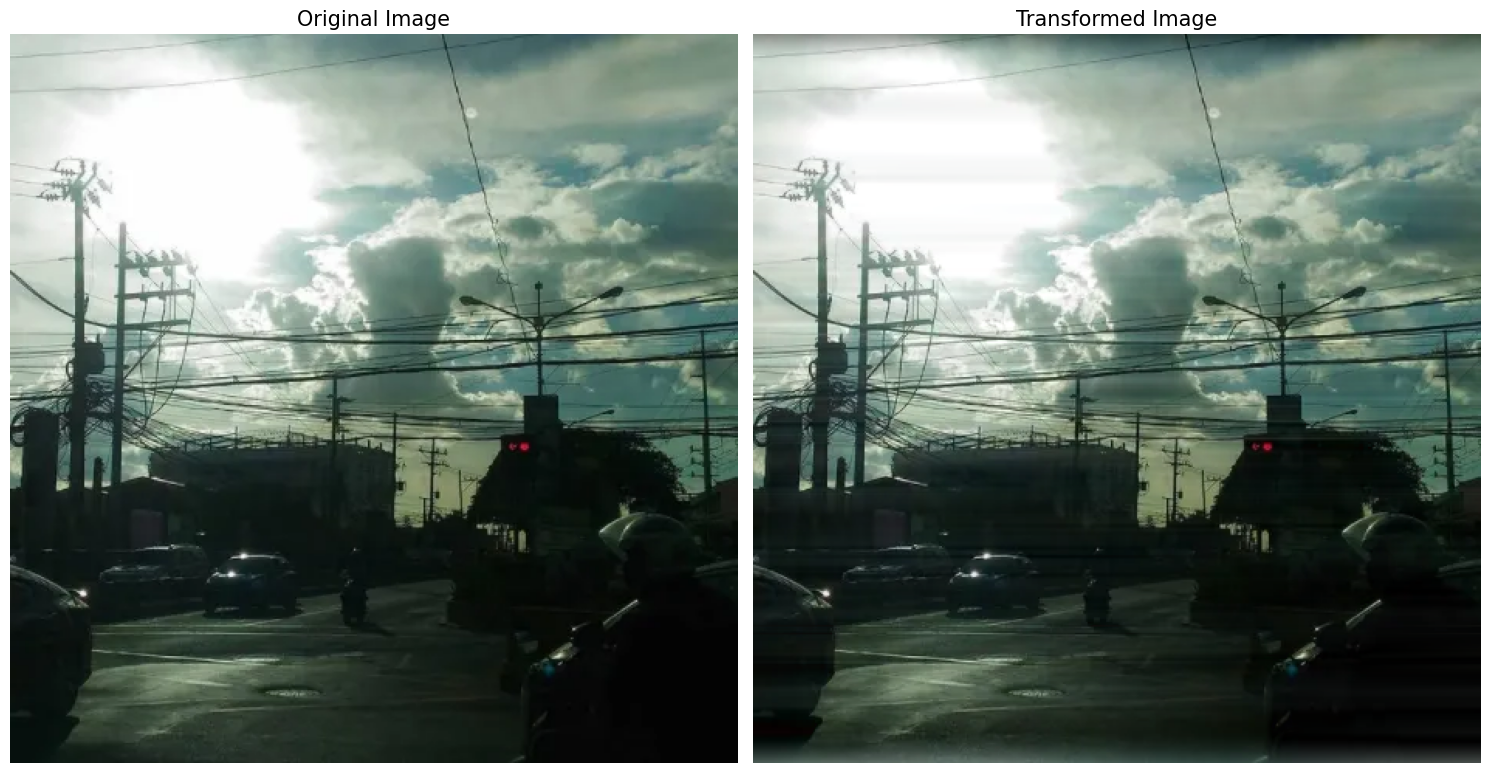

In [ ]:
def fourier_transform_rgb(image):
    f_size = 15
    transformed_channels = []
    for i in range(3):
        rgb_fft = np.fft.fftshift(np.fft.fft2((image[:, :, i])))
        rgb_fft[:225, 235:237] = 1
        rgb_fft[-225:,235:237] = 1
        transformed_channels.append(abs(np.fft.ifft2(rgb_fft)))

    final_image = np.dstack([transformed_channels[0].astype(int),
                             transformed_channels[1].astype(int),
                             transformed_channels[2].astype(int)])

    fig, ax = plt.subplots(1, 2, figsize=(15,15))
    ax[0].imshow(image)
    ax[0].set_title('Original Image', fontsize = f_size)
    ax[0].set_axis_off()

    ax[1].imshow(final_image)
    ax[1].set_title('Transformed Image', fontsize = f_size)
    ax[1].set_axis_off()

    fig.tight_layout()

fourier_transform_rgb(dark_image)

In [ ]:
def compress_image(image, percentage=0.1):
    """
    Compresses the given image using Fourier Transform.

    :param image: Input image to be compressed.
    :param percentage: Percentage of coefficients to keep. Default is 10%.
    :return: Compressed image.
    """
    # Convert the image to grayscale
    image_grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply the 2D Fourier Transform
    image_fourier = np.fft.fftshift(np.fft.fft2(image_grey))

    # Flatten the Fourier coefficients and sort by magnitude
    flattened = np.abs(image_fourier).flatten()
    sorted_indices = np.argsort(flattened)

    # Zero out the smallest coefficients
    num_to_zero = int((1 - percentage) * len(flattened))
    smallest_indices = sorted_indices[:num_to_zero]
    for index in smallest_indices:
        x, y = np.unravel_index(index, image_fourier.shape)
        image_fourier[x, y] = 0

    # Apply the inverse 2D Fourier Transform
    compressed_image = np.fft.ifft2(np.fft.ifftshift(image_fourier))
    return np.abs(compressed_image).astype(np.uint8)

# Example usage:
compressed_dark_image = compress_image(dark_image, 0.1)
plt.figure(figsize=(10, 10))
plt.imshow(compressed_dark_image, cmap='gray')
plt.title('Compressed Image')
plt.show()


Podemos ver que los cables de alimentación horizontales se han reducido considerablemente, mientras que el resto de la imagen permanece prácticamente intacta. Esto demuestra cómo podemos introducir cambios sutiles en una imagen mediante la transformación de Fourier.